## Tranformer Aggregation

This notebook contains the functions used to get aggregate load on a transformer.

In [1]:
import getpass
import urllib.parse

import datetime
import pytz
import calendar

from math import floor, ceil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_theme()

In [2]:
print('\nEDM login information')

edm_address = getpass.getpass(prompt='EDM server address: ')
edm_name = getpass.getpass(prompt='Username: ')
edm_password = getpass.getpass(prompt='Password: ')
edm_password = urllib.parse.quote(edm_password)

%load_ext sql
%sql postgresql://$edm_name:$edm_password@$edm_address/edm
%config SqlMagic.displaycon = False
%config SqlMagic.feedback = False

# Delete the credential variables for security purpose.
del edm_name, edm_password

EDM server address: ········

EDM login information
Username: ········
Password: ········


### Functions:

- agg: takes a list of meters and downstream transformer data between two specified dates and gives the load from the specified elements in hourly steps between those dates
    - Load in kVA is aggregated using the formula $\sum_i P_i$, where the sum is over all downstream meters and transformers.
            
    
- transformer_aggregate: takes a transformer grid_element_id and two dates, and returns the load on that transformer in hourly steps between those dates

In [3]:
### Global variables

power_factor = 0.98

charger_power = None
charger_voltage = None
transformer_id = None
start_date = None
end_date = None
full_transformer_list = None

transformer_capacity_data = {}

In [6]:
def setup():
    '''Collects user values for charger power, charger voltage, date range, and the transformer name.'''
    
    
    global charger_power
    global charger_voltage
    global transformer_id
    global start_date
    global end_date
    
    global full_transformer_list
    
    try:
        charger_power = float(input("Charger power draw in kW: "))
    except:
        raise Exception("Input could not be parsed. Please input only the numerical part of the charger's power draw.")

    try:
        charger_voltage = int(input("Charger voltage in V: "))
    except:
        raise Exception("Input could not be parsed. Please input only the numerical part of the charger's voltage.")

    transformer_id = input("Transformer ID: ")
    
    
    if full_transformer_list is None:
        
        transformers_sql = %sql SELECT grid_element_id AS g_id \
                            FROM grid_element \
                            WHERE type = 'Transformer' \
                                AND grid_id = 'awefice';

        full_transformer_list = transformers_sql.DataFrame()['g_id'].tolist()
    
    
    if not(transformer_id in full_transformer_list):
        transformer_id = None
        
        raise Exception("Transformer ID does not match any transformers on the grid.")
        
    start_date = input("Start date and time of range: ")
    end_date = input("Start date and time of range: ")
    
    
def update_date_range():
    '''Updates user values for date range.'''
    
    
    global start_date
    global end_date
    
    
    start_date = input("Start date and time of range: ")
    end_date = input("Start date and time of range: ")
        

### Aggregator functions


def agg(meters, start_date, end_date):
    '''Takes a list of grid elements and aggregates their load.
    
                 Parameters:
                         meters (List of str): list of grid_element_ids of all meters to aggregate
                         transformer_data (List of DataFrames): list of pandas databases containing the aggregated 
                                                                     data for connected transformers
                                                                     
                                                                     Dataframes will contain 3 columns:
                                                                         timestamp
                                                                         load in kWh
                                                                         
                         start_date (str): start date of time series range
                         end_date (str): end date of time series range
    
    '''
    
    
    
    # Convert start_date, end_date from local timezone to UTC.
    
    v_tz = pytz.timezone('America/Vancouver')
    utc_tz = pytz.timezone('UTC')
    
    start_date = str(pd.Timestamp(ts_input = start_date, tz = v_tz).astimezone(utc_tz).asm8)
    end_date = str(pd.Timestamp(ts_input = end_date, tz = v_tz).astimezone(utc_tz).asm8)
    
    #get meter data
    
    meter_data = []
    timestamp_data = None
    
    
    for meter in meters:
        meter_data_sql = %sql SELECT tdss.timestamp AS timestamp, geds.grid_element_id AS g_id, \
                                    MAX(CASE WHEN metric_key = 'V' THEN tdss.value END) AS V, \
                                    MAX(CASE When metric_key = 'kWh' THEN tdss.value END) AS kWh \
                                FROM grid_element ge \
                                JOIN grid_element_data_source geds \
                                    ON geds.grid_id = ge.grid_id \
                                    AND geds.grid_element_id = ge.grid_element_id \
                                JOIN UNNEST(geds.metrics::TEXT[]) metric_key \
                                    ON true \
                                JOIN ts_data_source_select(geds.grid_element_data_source_id, metric_key, '[{start_date}, {end_date}]') tdss \
                                    ON true \
                                WHERE ge.grid_id = 'awefice' \
                                    AND ge.type = 'Meter' \
                                    AND ge.grid_element_id = :meter \
                                GROUP BY tdss.timestamp, geds.grid_element_id \
                                ORDER BY 1, 2;
        
        
        this_meter = meter_data_sql.DataFrame()
        
        if timestamp_data is None:
            timestamp_data = pd.DataFrame(this_meter.timestamp)
        
        #remove all columns except for timestamp and load, set index to timestamp
        
        this_meter = this_meter.drop(['v', 'g_id'], axis = 1)
        this_meter = this_meter.rename(columns = {'kwh': ('load_' + meter)})
        
        
        meter_data.append(this_meter[['load_' + meter]])
        
    
    if timestamp_data is None:
        raise Exception('No time series data was found for elements downstream of this transformer.')
    
    # add up loads and index on time
    
    loads = timestamp_data.join(meter_data)
    loads['timestamp'] = loads['timestamp'].apply(lambda x: pd.Timestamp(x).astimezone(v_tz).tz_localize(None).asm8)  
    loads = loads.set_index('timestamp')
    
    loads = loads.sum(axis = 1)
        
    return loads

def transformer_aggregate(transformer_id, start_date, end_date):
    ''' Takes transformer_id, returns dataframe with aggregated load time series for
        times between start_date and end_date.
        
        Will only recompute data if the needed data has not been queried before.
    
                Parameters:
                        transformer_id (str): grid_element_id of transformer
                        start_date (str): start date of time series range
                        end_date (str): end date of time series range
                        upstream_transformers (bool): flag which determines whether to look at upstream
                                                        transformers
    
        
    '''
    
    global transformer_capacity_data
    
    
    if transformer_id in transformer_capacity_data.keys():
        if (transformer_capacity_data[transformer_id][0] >= datetime.datetime.fromisoformat(start_date)) and \
            (transformer_capacity_data[transformer_id][1] <= datetime.datetime.fromisoformat(end_date)):
        
            t = transformer_capacity_data[transformer_id][2]
        
            return t[(t.index >= datetime.datetime.fromisoformat(start_date)) & 
                     (t.index <= datetime.datetime.fromisoformat(end_date))]
    
    
    global power_factor
    
    
    #Collect all downstream transformers and aggregate on them.
    
    dt_sql = %sql   SELECT grid_element_id AS g_id\
                    FROM grid_get_downstream('awefice', :transformer_id, false) \
                    WHERE type = 'Transformer';
    
    downstream_transformer_data = []
    
    if dt_sql.DataFrame().shape[0] != 0:
    
        downstream_transformers = dt_sql.DataFrame()['g_id'].tolist()
    
        for transformer in downstream_transformers:
            
            dt = transformer_aggregate(transformer, start_date, end_date)['load']
            downstream_transformer_data.append(dt)
    
    else:
        downstream_transformers = []
        
        
    # Next, collect all meters on this transformer and aggregate on them.
    
    # grid_get_downstream gets ALL meters downstream, not just those that are directly connected
    #    to this transformer. So, we'll need to iterate through all downstream transformers and remove those
    #    from our meter list.
    
    m_sql = %sql   SELECT grid_element_id \
                    FROM grid_get_downstream('awefice', :transformer_id, false) \
                    WHERE type = 'Meter';
    
    meters = m_sql.DataFrame().grid_element_id.tolist()
    
    meters_to_exclude = []
    
    for transformer in downstream_transformers:
        dt_m_sql = %sql  SELECT grid_element_id \
                            FROM grid_get_downstream('awefice', :transformer, false) \
                            WHERE type = 'Meter';
        
        meters_to_exclude = meters_to_exclude + dt_m_sql.DataFrame().grid_element_id.tolist()
        
    meters = [m for m in meters if m not in meters_to_exclude]
    
    
    
    # Get characteristics of transformer: rating_kva and phase
    
    meta_sql = %sql SELECT meta_data.key, meta_data.value \
                        FROM grid_element ge \
                        JOIN json_each_text(ge.meta::json) meta_data \
                            ON true \
                        WHERE ge.grid_element_id = :transformer_id \
                            AND (meta_data.key = 'secondary_voltage' \
                                 OR meta_data.key = 'rating_kva');
    
    meta = meta_sql.DataFrame().set_index('key')
    
    rating_kva = float(meta.loc['rating_kva','value'])
    
    aggregate_load = None
    
    if len(meters) > 0:
        aggregate_load = pd.DataFrame(agg(meters, start_date, end_date), columns = ['load'])
        
        if len(downstream_transformer_data) > 0:
            for i in range(0, len(downstream_transformer_data)):
                downstream_transformer_data[i] = downstream_transformer_data[i].rename('load'+ str(i))
            
            aggregate_load = aggregate_load.join(downstream_transformer_data)
            aggregate_load = pd.DataFrame(aggregate_load.sum(axis = 1), columns = ['load'])
        
        
    else: 
        
        if len(downstream_transformer_data) == 0:
            ### TODO: change this to initialize a column of 0s for load. The problem is getting the list of timestamps.
            
            raise Exception('No data to aggregate: no downstream meters or transformers.')
            
        else:
            for i in range(0, len(downstream_transformer_data)):
                downstream_transformer_data[i] = downstream_transformer_data[i].rename('load'+ str(i))
            
            aggregate_load = pd.DataFrame(downstream_transformer_data[0])
            
            aggregate_load = aggregate_load.join(downstream_transformer_data[1:])
            aggregate_load = pd.DataFrame(aggregate_load.sum(axis = 1), columns = ['load'])
            
    
    aggregate_load['Excess Capacity'] = int(rating_kva)*(power_factor) - aggregate_load['load']
    
    a = pd.DataFrame(aggregate_load['Excess Capacity'])
    
    transformer_capacity_data[transformer_id] = (a.index[0],
                                                 a.index[-1],
                                                 a)
    
    return a


def fit_EVCs(budget = 1.0, transformer = None):
    '''Determines the number of electric vehicle chargers, with the given parameters, fit within excess capacity
        on the specified transformer on an hourly basis.
        
        Assumes that the charger_power, charger_voltage, and transformer_id variables have been set, for example
        by running setup().
    '''
    
    global charger_power
    global charger_voltage
    global transformer_id
    global start_date
    global end_date
    
    
    if transformer_id is None:
        raise Exception('Run setup() before attempting to fit chargers.')
    
    
    if transformer is None:
        transformer = transformer_id
    
    data = transformer_aggregate(transformer, start_date, end_date)
    
    
    secondary_voltage_sql = %sql SELECT meta_data.value \
                                 FROM grid_element ge \
                                 JOIN json_each_text(ge.meta::json) as meta_data \
                                     ON true \
                                 WHERE ge.grid_id = 'awefice' \
                                     AND ge.grid_element_id = :transformer_id \
                                     AND meta_data.key = 'secondary_voltage';
        
    secondary_voltage = int(secondary_voltage_sql.DataFrame().iloc[0,0])
    
    if charger_voltage > secondary_voltage:
        raise Exception("Charger voltage is higher than transformer secondary voltage. Charger cannot be installed downstream of this transformer.")
    
    
    data['Budgeted Capacity'] = data['Excess Capacity']*budget
    
    data['EVCs'] = (data['Budgeted Capacity']/charger_power).apply(lambda x: max(floor(x),0))
    
    return data


def meter_capacity(meter_id, start_date, end_date):
    '''Returns a DataFrame containing hourly current and excess capacity measurements for the given meter.
    
                Parameters:
                            meter_id (str): grid_element_id of meter
                            start_date (str): start date of time series range
                            end_date (str): end date of time series range
                
    '''
    
    
    meter_data_sql = %sql SELECT tdss.timestamp AS timestamp, \
                                    MAX(CASE WHEN metric_key = 'V' THEN tdss.value END) AS V, \
                                    MAX(CASE When metric_key = 'kWh' THEN tdss.value END) AS kWh \
                                FROM grid_element ge \
                                JOIN grid_element_data_source geds \
                                    ON geds.grid_id = ge.grid_id \
                                    AND geds.grid_element_id = ge.grid_element_id \
                                JOIN UNNEST(geds.metrics::TEXT[]) metric_key \
                                    ON true \
                                JOIN ts_data_source_select(geds.grid_element_data_source_id, metric_key, '[{start_date}, {end_date}]') tdss \
                                    ON true \
                                WHERE ge.grid_id = 'awefice' \
                                    AND ge.type = 'Meter' \
                                    AND ge.grid_element_id = :meter_id \
                                GROUP BY tdss.timestamp, geds.grid_element_id \
                                ORDER BY 1, 2;
        
        
    meter_data = meter_data_sql.DataFrame()
    
    meter_data['timestamp'] = meter_data['timestamp'].apply(lambda x: pd.Timestamp(x).asm8)
    meter_data = meter_data.set_index('timestamp')
    
    meter_data['current (A)'] = 1000*meter_data['kwh']/meter_data['v']
    
    
    meta_sql = %sql SELECT meta_data.key, meta_data.value \
                        FROM grid_element ge \
                        JOIN json_each_text(ge.meta::json) meta_data \
                            ON true \
                        WHERE ge.grid_element_id = :meter_id \
                            AND (meta_data.key = 'maximal_demand');
        
    
    maximal_demand = int(meta_sql.DataFrame().iloc[0,1])
    
    meter_data['Excess Capacity'] = maximal_demand - meter_data['current (A)']
    meter_data = meter_data.drop(['kwh', 'v'], axis = 1)
    
    return meter_data
    
    
    
### Graph traversal functions

### Note, we are assuming that each distribution transformer only has one upstream step down transformer between
###       the distribution transformer and the substation.

def find_root_transformer(grid_element_id, grid_id):
    '''Takes a grid element and finds the root transformer upstream of it.
    
            Parameters:
                    grid_element_id (String): the grid element to trace
                    grid_id (String): the grid to work on
            
    '''
    
    upstream_transformers_sql = %sql    SELECT grid_element_id \
                                        FROM grid_get_sources(:grid_id, :grid_element_id, false) \
                                        WHERE type = 'Transformer';
    
    

    if upstream_transformers_sql.DataFrame().shape[0] == 0:
        return transformer_id
    else:
        return find_root_transformer(upstream_transformers_sql.DataFrame().iloc[0,0])
    
def get_dt_tr(transformer_id):
    '''Returns the list of all transformers downstream of transformer_id.'''
    
    
    dt_sql = %sql   SELECT grid_element_id AS g_id\
                        FROM grid_get_downstream('awefice', :transformer_id, false) \
                        WHERE type = 'Transformer';
    
    if pd.DataFrame(dt_sql).shape[0] != 0:
    
        return pd.DataFrame(dt_sql)['g_id'].tolist()
    
    else:
        return []
    
    

### Visualization functions
        
def graph_excess_capacity(start_date, end_date, 
                          bins = 40, 
                          transformers = None, 
                          aggregator = 'mean', 
                          ax = None,
                          figwidth = 12, figheight = 6):
    ''' Graphs the excess capacity for each transformer in a list of transformers.
        
                Parameters:
                        start_date (String): start date of time series range
                        end_date (String): end date of time series range
                        bins (int): Number of intervals to graph. Data within each interval is averaged to
                                            give a single capacity number on that interval.
                        trasformers(list of Strings): list of grid_element_ids of transformers to plot.
                                                        If list is None, plot them all.
                        aggregator (String): if there are more timestamps than bins, specifies method to
                                                    aggregate on each bin. Options are 'mean', 'min'.
                                                        'mean': take the average excess capacity in each time interval
                                                        'min': take the minimum excess capacity in each time interval
                                                        'both': plot both average and minimum on the same axes
                        ax(matplotlib.axes): axis to graph on if a common plot is desired.
                        figwidth, figheight (int): if ax is not given, generate an axis with these dimensions.
    '''
    
    
    
    if transformers is None:
        transformers_sql = %sql SELECT grid_element_id \
                                    FROM grid_element \
                                    WHERE type = 'Transformer';
        
        transformers = transformers_sql.DataFrame()['grid_element_id'].tolist()
    
    if type(transformers) == str:
        transformers = [transformers]
    
    
    if len(transformers) == 0:
        raise Exception('No transformer_ids given to graph.')
    else:
        capacity_data = transformer_aggregate(transformers[0], start_date, end_date)
        capacity_data = capacity_data.rename(columns = {'Excess Capacity': transformers[0]})
    
    for j in range(1,len(transformers)):
        
        capacity_data[transformers[j]] = transformer_aggregate(transformers[j], start_date, end_date)['Excess Capacity']
    
    
    start_dt = datetime.datetime.fromisoformat(start_date)
    end_dt = datetime.datetime.fromisoformat(end_date)
    
    if ax == None:
        fig, ax = plt.subplots(figsize = (figwidth, figheight))
    
    if (end_dt - start_dt)/3600 < datetime.timedelta(hours = bins)/3600:
        
        sns.lineplot(data = capacity_data, x = 'timestamp', y = 'Excess capacity', ax = ax)
            
    else:
        
        loads_d = {}
        loads_d_min = {}
        loads_d_mean = {}
        
        for i in range(0, bins):
            sub_start = pd.Timestamp(start_dt + (i/bins)*(end_dt - start_dt)).asm8
            sub_end = pd.Timestamp(start_dt + ((i+1)/bins)*(end_dt - start_dt)).asm8
            
            #Making a choice to label each time interval with its end time.
            if aggregator == 'mean':
                
                loads_d[sub_end] = (capacity_data[(capacity_data.index > sub_start) 
                                                  & (capacity_data.index <= sub_end)]).mean()
            elif aggregator == 'min':
                
                loads_d[sub_end] = (capacity_data[(capacity_data.index > sub_start) 
                                                  & (capacity_data.index <= sub_end)]).min()
            elif aggregator == 'both':
                
                
                loads_d_mean[sub_end] = (capacity_data[(capacity_data.index > sub_start) 
                                                  & (capacity_data.index <= sub_end)]).mean()
                loads_d_min[sub_end] =  (capacity_data[(capacity_data.index > sub_start) 
                                                  & (capacity_data.index <= sub_end)]).min()
                
            else:
                raise Exception('aggregator not recognized. aggregator can be either "mean", "min", or "both".')
    
        if (aggregator == 'mean') or (aggregator == 'min'):
            loads_df = pd.DataFrame.from_dict(loads_d, orient = 'index')
        else:
            loads_df = pd.DataFrame.from_dict(loads_d_min, orient = 'index').add_suffix('_min')
            loads_df = loads_df.join(pd.DataFrame.from_dict(loads_d_mean, orient = 'index').add_suffix('_avg'))
        
        sns.lineplot(data = loads_df, ax = ax)
        
    
    title_mod = ""
    
    if aggregator == 'min':
        title_mod = 'Minimum '
        plt.legend(labels = transformers, loc='right', bbox_to_anchor=(1.2,0.85))
    elif aggregator == 'mean':
        title_mod = 'Average '
        plt.legend(labels = transformers, loc='right', bbox_to_anchor=(1.2,0.85))
    else:
        title_mod = 'Average and minimum '
        
        transformer_suffix = [(tr + ' minimum') for tr in transformers] + [(tr + ' average') for tr in transformers]
        plt.legend(labels = transformer_suffix, loc='upper left', bbox_to_anchor=(1,0.95))
    
    
    plt.title(title_mod + "excess capacity on transformers")
    plt.xticks(rotation=45)
    plt.ylabel('Excess Capacity (kVA)')
    plt.show()
    
    
    
def graph_by_day():
    
    global start_date
    global end_date
    
    days_d = dict(enumerate(calendar.day_name))
    
    
    
    charger_data = fit_EVCs()
    
    charger_data['Day'] = charger_data.index.dayofweek
    charger_data['Day'] = charger_data['Day'].apply(lambda x: days_d[x])
    
    sns.boxenplot(data = charger_data, x = 'Day', y = 'EVCs')
    
def graph_EVC_capacity():
    
    global charger_power
    
    charger_data = fit_EVCs().drop(['Excess Capacity', 'Budgeted Capacity'], axis = 1)
    
    
    ax = plt.subplot()
    ax.yaxis.get_major_locator().set_params(integer=True)
    
    sns.lineplot(data = charger_data, ax = ax)
    plt.xticks(rotation = '45')
    plt.show()
    
def graph_power_scenarios(budget = 1.0):
    
    global charger_power
    global transformer_id
    
    charger_data = fit_EVCs(budget = budget).drop(['Excess Capacity', 'EVCs'], axis = 1)
    
    
    charger_data = parse_date_time(charger_data).drop(['year', 'day', 'weekday'], axis = 1)
    
    
    hourly_min = charger_data.drop('month', axis = 1).groupby(by = 'hour').min()
    summer_hourly_min = charger_data[(charger_data['month'] >= 6) & (charger_data['month'] <= 9)] \
                                     .drop('month', axis = 1) \
                                     .groupby(by = 'hour').min()
    
    
    
    #hourly_avg = charger_data.drop('month', axis = 1).groupby(by = 'hour').mean()
    #summer_hourly_avg = charger_data[(charger_data['month'] >= 6) & (charger_data['month'] <= 9)] \
    #                                 .drop('month', axis = 1) \
    #                                 .groupby(by = 'hour').mean()
    
    
    charger_data['date'] = charger_data.index.date
    charger_data = charger_data.drop(['month'], axis = 1)
    
    
    daily_min = charger_data.drop('hour', axis = 1).groupby(by = 'date').min()
    daily_min = daily_min.rename(columns = {'Budgeted Capacity': 'Minimum daily capacity'})
    
    daily_nightly_min = charger_data[(charger_data['hour'] >= 22) | (charger_data['hour'] <= 4)] \
                                        .drop('hour', axis = 1) \
                                        .groupby(by = 'date').min()
    
    daily_nightly_min = daily_nightly_min.rename(columns = {'Budgeted Capacity': 'Minimum nightly capacity'})
    
    
    
    total_min = hourly_min.min()[0]
    nightly_min = hourly_min[(hourly_min.index <= 4) | (hourly_min.index >= 22)].min()[0]
    summer_total_min = summer_hourly_min.min()[0]
    summer_nightly_min = summer_hourly_min[(hourly_min.index <= 4) | (hourly_min.index >= 22)].min()[0]
    
    
    
    
    charger_data = charger_data.drop(['hour', 'date', 'Budgeted Capacity'], axis = 1)
    
    
    fig, ax = plt.subplots(figsize = (14,8))
    ax.yaxis.get_major_locator().set_params(integer=True)
    
    
    charger_data['Used Capacity - Max any time'] = floor(total_min/charger_power)*charger_power
    charger_data['Used Capacity - Max at night'] = floor(nightly_min/charger_power)*charger_power
    charger_data['Used Capacity - Max at summer'] = floor(summer_total_min/charger_power)*charger_power
    charger_data['Used Capacity - Max at summer night'] = floor(summer_nightly_min/charger_power)*charger_power
    
    sns.lineplot(data = daily_min, ax = ax, palette = 'Greens')
    sns.lineplot(data = daily_nightly_min, ax = ax, palette = 'Blues')
    sns.lineplot(data = charger_data, ax = ax, palette = 'copper')
    
    
    for line in ax.lines:
        
        data_x, data_y = line.get_data()
        
        
        if len(data_y) > 0:
            
            right_most_x = data_x[-1]
            right_most_y = data_y[-1]
            
            label = -1
            
            if data_y[0] == floor(total_min/charger_power)*charger_power:
                label = floor(total_min/charger_power)
            if data_y[0] == floor(nightly_min/charger_power)*charger_power:
                label = floor(nightly_min/charger_power)
            if data_y[0] ==  floor(summer_total_min/charger_power)*charger_power:
                label = floor(summer_total_min/charger_power)
            if data_y[0] ==  floor(summer_nightly_min/charger_power)*charger_power:
                label = floor(summer_nightly_min/charger_power)
            
            if label != -1:
                ax.annotate(
                    str(label) + '\nchargers' ,
                    xy=(right_most_x, right_most_y),
                    xytext=(0,0),
                    textcoords="offset pixels",
                    va="center",
                    color=line.get_color()
                )
            
        
    plt.legend(loc='upper left', bbox_to_anchor=(1.05,0.95))
    
    plt.xticks(rotation = '45')
    plt.xlabel('Date')
    
    
    plt.yticks(ticks = [floor(total_min/charger_power)*charger_power,
                        floor(nightly_min/charger_power)*charger_power,
                        floor(summer_total_min/charger_power)*charger_power,
                        floor(summer_nightly_min/charger_power)*charger_power])
    plt.ylabel('Capacity (kVA)')
    
    plt.title('Charger thresholds for ' + str(charger_power) + 'kW chargers on ' + transformer_id)
    
    plt.show()


def graph_chargers_on(transformers, budgets = 1.0):
    '''Takes a list of transformers and a list of budgets for each transformer and graphs the chargers
        that will fit on each transformer within the budget specified. Each graph contains four scenarios:
            - The chargers never pull more than the budgeted capacity.
            - The chargers never pull more than the budgeted capacity at night.
            - The chargers never pull more than the budgeted capacity during the summer.
            - The chargers never pull more than the budgeted capacity during summer nights.
                
                
                    Parameters:
                            - transformers (list of str): a list of transformers to graph
                            - budgets (float or list of float): budget is given as a percentage of available capacity.
                                                                If budgets is a float, the same percentage will be used for
                                                                    every transformer.
    '''
    
    global charger_power
    global full_transformer_list
    
    if type(transformers) is not list:
        raise Exception('Transformers must be supplied as a list.')
    
    
    for transformer in transformers:
        
        if full_transformer_list is None: 
            transformers_sql = %sql SELECT grid_element_id AS g_id \
                            FROM grid_element \
                            WHERE type = 'Transformer' \
                                AND grid_id = 'awefice';
            
            full_transformer_list = full_transformer_list = transformers_sql.DataFrame()['g_id'].tolist()
            
        if not(transformer in full_transformer_list):
            raise Exception('Transformer list contains ID that does not match any transformers on the grid.')
        
        
    if type(budgets) is float:
        budgets = [budgets]*len(transformers)
    
    for budget in budgets:
        if type(budget) is not float:
            raise Exception('Budgets must be provided as numbers between 0 and 1.')
                            
    cols = min(4, len(transformers), ceil(np.sqrt(len(transformers))))                               #Number of columns to display the graphs in.
    rows = ceil(len(transformers)/cols)
                            
    fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (16,rows*5))
    
    if len(transformers) > 1:
        for i in range(len(transformers), len(axs.flatten())):
            axs.flatten()[i].set_axis_off()
        
    
    for i in range(0, len(transformers)):
        
        if len(transformers) > 1:
            ax = axs.flatten()[i]
        else:
            ax = axs
        
        charger_data = fit_EVCs(budgets[i], transformers[i]).drop(['Excess Capacity', 'EVCs'], axis = 1)
        charger_data = parse_date_time(charger_data).drop(['year', 'day', 'weekday'], axis = 1)
    
    
        hourly_min = charger_data.drop('month', axis = 1).groupby(by = 'hour').min()
        summer_hourly_min = charger_data[(charger_data['month'] >= 6) & (charger_data['month'] <= 9)] \
                                     .drop('month', axis = 1) \
                                     .groupby(by = 'hour').min()
    
    
        charger_data['date'] = charger_data.index.date
        charger_data = charger_data.drop(['month'], axis = 1)
    
    
        daily_min = charger_data.drop('hour', axis = 1).groupby(by = 'date').min()
        daily_min = daily_min.rename(columns = {'Budgeted Capacity': 'Minimum daily capacity'})
    
        daily_nightly_min = charger_data[(charger_data['hour'] >= 22) | (charger_data['hour'] <= 4)] \
                                        .drop('hour', axis = 1) \
                                        .groupby(by = 'date').min()
        daily_nightly_min = daily_nightly_min.rename(columns = {'Budgeted Capacity': 'Minimum nightly capacity'})
    
    
    
        total_min = hourly_min.min()[0]
        nightly_min = hourly_min[(hourly_min.index <= 4) | (hourly_min.index >= 22)].min()[0]
        summer_total_min = summer_hourly_min.min()[0]
        summer_nightly_min = summer_hourly_min[(hourly_min.index <= 4) | (hourly_min.index >= 22)].min()[0]
                            
                            
        d = {
             'Nights' : max(floor(nightly_min/charger_power),0.1),
             'All time' : max(floor(total_min/charger_power),0.1),
             'Summer nights' : max(floor(summer_nightly_min/charger_power),0.1),
             'Summer' : max(floor(summer_total_min/charger_power),0.1)
            }
                   
        df = pd.DataFrame().from_dict(d, orient = 'index', columns = [transformers[i]])
                            
        sns.barplot(data = df, x = df.index, y = df[transformers[i]], palette = 'CMRmap', ax = ax)
        
        if (d['All time'] < 5) and (d['Nights'] < 5) and (d['Summer'] < 5) and (d['Summer nights'] < 5):
            ax.set_yticks(ticks = [0,1,2,3,4,5])
        
        
        ax.tick_params('x', labelrotation= 45)
        
        ax.set_ylabel('kVA')
        ax.set_xlabel('Time interval for capacity')
        
        transformer_number = transformers[i].split('_')[1]
        
        ax.set_title('Chargers that fit on transformer ' + transformer_number)
    
    fig.subplots_adjust(hspace = 0.7, wspace = 0.3)
    
    
    plt.show()

    
### Summary Statistics


def transformer_summary():
    
    ''' Prints basic summary statistics for excess capacity and possible EV charger support for user\'s transformer.
    
    
        Prints maximum and minimum excess capacity over the chosen time range, as well as maximum and minimum
            supported EV chargers, assuming full utilization of excess capacity. This assumes full
            utilization of each EV charger at all times.
    
    '''
    
    global transformer_id
    global charger_power
    global start_date
    global end_date
    
    data = fit_EVCs()
    
    max_excess = data['Excess Capacity'].max()
    min_excess = data['Excess Capacity'].min()
    
    max_EVCs = data['EVCs'].max()
    min_EVCs = data['EVCs'].min()
    
    print('Summary for transformer ' + transformer_id + ' between ' + start_date + ' and ' + end_date)
    print('='*len('Summary for transformer ' + transformer_id + ' between ' + start_date + ' and ' + end_date))
    print(f"Maximum excess capacity: {str(max_excess) + ' kVA':<29} Minimum excess capacity: {min_excess} kVA")
    print(f"Maximum chargers using all excess capacity: {max_EVCs :<10} Minimum chargers using all excess capacity: {min_EVCs}")
    
    
    
### Helper functions

def parse_date_time(df):
    '''Parses datetime information from timestamps in the index.'''
    
    df = df.copy(deep = True)
    
    days_d = dict(enumerate(calendar.day_name))
    
    df['weekday'] = df.index.dayofweek
    df['weekday'] = df['weekday'].apply(lambda x: days_d[x])
    
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    
    return df

### Getting and graphing transformer load data

Given a transformer_id, transformer_aggregate works as:

In [5]:
transformer_id = 'transformer_63'
meter_id = 'm_12'
start_date = '2022-07-16'
end_date = '2022-07-22'

In [7]:
graph_excess_capacity(start_date, end_date, transformer_id, aggregator = 'min')

KeyError: 'load'

In [88]:
transformer_aggregate(transformer_id, start_date, end_date)

,Excess Capacity
timestamp,
2022-07-20 00:00:00,291.210
2022-07-20 01:00:00,291.802
2022-07-20 02:00:00,292.068
2022-07-20 03:00:00,292.126
2022-07-20 04:00:00,291.988
2022-07-20 05:00:00,291.728
2022-07-20 06:00:00,291.198
2022-07-20 07:00:00,291.036
2022-07-20 08:00:00,290.921


For a sanity check, we can compute this by hand with the data:

In [9]:
%%sql

SELECT tdss.timestamp, geds.grid_element_id, metric_key, tdss.value
FROM grid_get_downstream('awefice', :transformer_id) ggd
JOIN grid_element_data_source geds
    ON geds.grid_id = ggd.grid_id
    AND geds.grid_element_id = ggd.grid_element_id
JOIN UNNEST(geds.metrics::TEXT[]) metric_key
    ON true
JOIN ts_data_source_select(geds.grid_element_data_source_id, metric_key, '[{start_date}, {end_date}]') tdss
    ON true
WHERE ggd.grid_id = 'awefice'
    AND ggd.type = 'Meter'
ORDER BY 1, 3, 2
LIMIT 20;

timestamp,grid_element_id,metric_key,value
2021-01-01 08:00:00+00:00,m_22,kWh,2.094
2021-01-01 08:00:00+00:00,m_23,kWh,1.892
2021-01-01 08:00:00+00:00,m_24,kWh,5.471
2021-01-01 08:00:00+00:00,m_25,kWh,1.918
2021-01-01 08:00:00+00:00,m_26,kWh,4.352
2021-01-01 08:00:00+00:00,m_27,kWh,2.173
2021-01-01 08:00:00+00:00,m_22,V,227.949
2021-01-01 08:00:00+00:00,m_23,V,227.894
2021-01-01 08:00:00+00:00,m_24,V,229.716
2021-01-01 08:00:00+00:00,m_25,V,229.184


Checking for transformer_16:

So, by hand, we should have at 12am that aggregate current is:

$$\text{secondary current} = \frac{0.547}{121.468} + \frac{0.595}{120.877} + \frac{0.539}{120.613} = 0.013894$$

Note that this is in kiloamperes, so to get kVA we multiply this by secondary voltage to get secondary load $0.013894 \times 120 \approx 1.667333$.

So excess capacity is (rating_kva x PF - secondary load).

Graphing excess capacity on a grid element can be done with graph_excess_capacity. This can be used to graph excess capacity on either transformers or meters. The type needs to be passed along with the grid_element_id.

For a transformer:

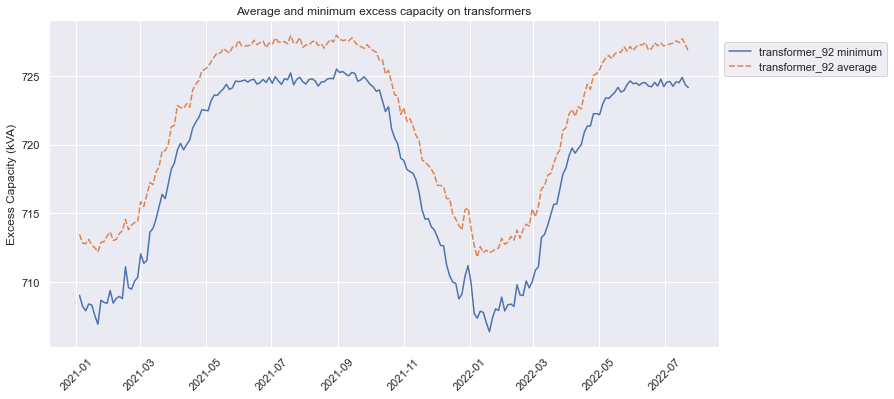

In [120]:
#graph_excess_capacity(start_date, end_date, bins = 200, transformers = transformer_id, aggregator = 'mean')
graph_excess_capacity(start_date, end_date, bins = 200, transformers = transformer_id, aggregator = 'min')
#graph_excess_capacity(start_date, end_date, bins = 200, transformers = transformer_id, aggregator = 'both')

For finding excess capacity on the meter level, we have meter_capacity:

In [236]:
meter_capacity(meter_id, start_date, end_date)

,current (A),Excess Capacity
timestamp,,
2021-01-01 08:00:00,9.907869,20.092131
2021-01-01 09:00:00,10.638409,19.361591
2021-01-01 10:00:00,10.968948,19.031052
2021-01-01 11:00:00,10.375855,19.624145
2021-01-01 12:00:00,11.797311,18.202689
...,...,...
2022-07-19 20:00:00,8.205192,21.794808
2022-07-19 21:00:00,7.788671,22.211329
2022-07-19 22:00:00,7.397228,22.602772


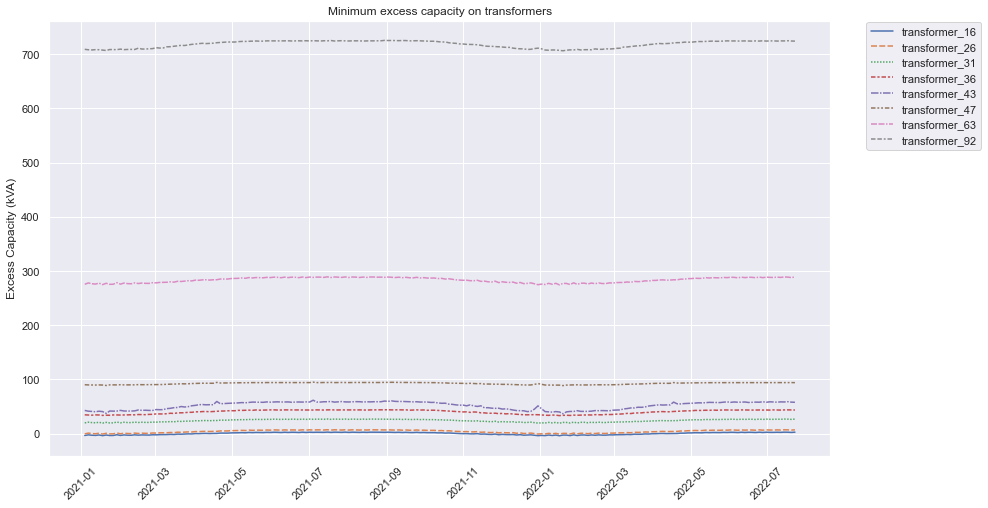

In [119]:
transformer_sql = %sql SELECT grid_element_id\
                        FROM grid_element \
                        WHERE type = 'Transformer'

all_transformers = transformer_sql.DataFrame()['grid_element_id'].tolist()

fig, ax = plt.subplots(figsize = (14,8))

graph_excess_capacity(start_date, end_date, bins = 200, transformers = all_transformers[2:], ax = ax, aggregator = 'min')

### Transformer Load Excess Plots

Let's plot the load and excess of different transformers over time to see which transformers can afford extra `EV Chargers`.

Selecting a wide range to see the trend over almost a year, more specifically the `Fall`, `Winter` and `Spring`. It is expected that the load will always be less in the `Summer`.

In [1]:
start_date = '2021-10-01'
end_date = '2022-03-31'

We first look at `transformer_16`

In [ ]:
%%capture
data_16 = transformer_aggregate('transformer_16', start_date, end_date)

In [ ]:
fig, ax = plt.subplots(figsize=(15,9))

plt.plot(data_16.index, data_16['load'])

plt.xlabel("datetime") 
plt.ylabel("$kVA$")
plt.title('transformer_16')

plt.show()

The above plot shows that the load in the `Winter` is highest as expected. But this plot is too convoluted to gain any meaningful insight. Let us average the load and excess over a `week` and plot them in the same range as above.   

In [ ]:
fig , ax = plt.subplots(figsize=(15,9))
data_16.groupby([data_16.index.isocalendar().week], sort=False)[["load", "excess"]].mean().plot(kind='bar', stacked=True, rot=0, ax=ax)

plt.xlabel("week number") 
plt.ylabel("$kVA$")
plt.title('transformer_16 load/excess')
plt.show()

Well, the bar-plot shows in the `Winter` the excess is already negative!! That means the loads from the meters downstream of `transformer_16` are already too high and exceed the `max_load` of the transformer on certain weeks of the year.  

In [ ]:
%%capture
start_date = '2022-01-17'
end_date = '2022-01-24'
data_16 = transformer_aggregate('transformer_16', start_date, end_date)

In [ ]:
fig , ax = plt.subplots(figsize=(15,9))

data_16.groupby((pd.Grouper(freq='6H')))[["load", "excess"]].mean().plot(kind='bar', stacked=True, rot=60, ax=ax)

plt.ylabel("$kVA$")
plt.title('transformer_16 load/excess')

plt.show()

Illustrates the overloading in an even smaller interval (`6H`) over the week `'2022-01-17'-'2022-01-24'`.  

Doing the same analysis for `transformer_63`

In [ ]:
%%capture
start_date = '2021-10-01'
end_date = '2022-03-31'

data_63 = transformer_aggregate('transformer_63', start_date, end_date)

In [ ]:
fig, ax = plt.subplots(figsize=(15,9))

plt.plot(data_63.index, data_63['load'], label='load', color='r')
plt.plot(data_63.index, data_63['excess'], label='excess', color='g')
plt.legend()

plt.xlabel("datetime") 
plt.ylabel("$kVA$")
plt.title('transformer_63')

plt.show()

In [ ]:
fig , ax = plt.subplots(figsize=(15,9))
data_63.groupby(pd.Grouper(freq='W'))[["load", "excess"]].mean().plot(kind='bar', stacked=True, rot=60, ax=ax)

plt.xlabel("week number") 
plt.ylabel("$kVA$")
plt.title('transformer_63 load/excess')
plt.show()

### Load/Excess Bar-Plot for all Transformers Downstream of Transformer-2

In [ ]:
tr_down = get_dt_tr('transformer_2')
tr_down

start_date = '2021-10-01'
end_date = '2022-03-31'

In [ ]:
%%capture
tr_data = []
for i in range(len(tr_down)):
    tr_data.append(transformer_aggregate(tr_down[i], start_date, end_date))

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20,10), sharex=True)
fig.suptitle("Load/Excess data of all Transformers downstream of 'transformer_2'", fontsize=20)

for i in range(len(tr_data)):
    tr_data[i].groupby([tr_data[i].index.isocalendar().week], sort=False)[["load", "excess"]].mean().plot(kind='bar', stacked=True, rot=0, ax=axs[i%2,i%3])
    axs[i%2,i%3].set_title(tr_down[i], fontsize=15)
    axs[i%2,i%3].set_ylabel("$kVA$")

fig.tight_layout()
fig.show()

In [ ]:
%%capture
start_date = '2022-01-17'
end_date = '2022-01-24'
tr_data1 = []
for i in range(len(tr_down)):
    tr_data1.append(transformer_aggregate(tr_down[i], start_date, end_date))

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20,10), sharex=True)
fig.suptitle("Load/Excess data of all Transformers downstream of 'transformer_2' ('2022-01-17'-'2022-01-24')", fontsize=20)


for i in range(len(tr_data)):
    tr_data1[i].groupby((pd.Grouper(freq='6H')))[["load", "excess"]].mean().plot(kind='bar', stacked=True, fontsize=8, rot=90, ax=axs[i%2,i%3])
    axs[i%2,i%3].set_title(tr_down[i], fontsize=15)
    axs[i%2,i%3].set_ylabel("$kVA$")

fig.tight_layout()
fig.show()

### Load/Excess Bar-Plot for all Downstream Transformers from a given Root Transformer

All these can be summed up in the following function called `plot_load_excess`. The function takes the `transformer_id`, `start_date`, `end_date`, and `freq` as inputs and gives a load/excess plot for all the transformers downstream from it. Note that it will only work if the transformer has other transformers downstream of it. In the TGI grid example, this will work only for the two root transformers: `transformer_2` and `transformer_6`.  

In [ ]:
from math import ceil

def plot_load_excess(transformer_id, start_date, end_date, freq):
    ''' Parameters:
                transformer_id (String): grid_element_id of transformer
                start_date (String): start date of time series range
                end_date (String): end date of time series range
                freq (String): time interval over which we want to average our data, depends on the date range we want to plot 
                
            possible parameters to be added: kind(String): what kind of plot we want. Here I just used bar-plots. '''
    tr_down = get_dt_tr(transformer_id)

    rows = ceil(len(tr_down)/3)

    tr_data = []
    for i in range(len(tr_down)):
        tr_data.append(transformer_aggregate(tr_down[i], start_date, end_date))
    
    fig, axs = plt.subplots(rows, 3, figsize=(24,6*rows), sharex=True)
    
    fig.suptitle(f"Load/Excess data of all Transformers downstream of '{transformer_id}' ({start_date} - {end_date})", fontsize=20)

    if rows==1:
        for ax in axs:
            ax.set_axis_off()
        for i in range(len(tr_data)):
            tr_data[i].groupby((pd.Grouper(freq=freq)))[["load", "excess"]].mean().plot(kind='bar', stacked=True, fontsize=8, rot=90, ax=axs[i%3])
            axs[i%3].set_axis_on()
            axs[i%3].set_title(tr_down[i], fontsize=15)
            axs[i%3].set_ylabel("$kVA$")


    else:
        for i in range(rows):
            for j in range(3):
                axs[i][j].set_axis_off()
        for i in range(len(tr_data)):
            tr_data[i].groupby((pd.Grouper(freq=freq)))[["load", "excess"]].mean().plot(kind='bar', stacked=True, fontsize=8, rot=90, ax=axs[i%rows,i%3])
            axs[i%rows,i%3].set_axis_on()
            axs[i%rows,i%3].set_title(tr_down[i], fontsize=15)
            axs[i%rows,i%3].set_ylabel("$kVA$")
    
    return fig, axs 
    

In [ ]:
start_date = '2022-01-17'
end_date = '2022-01-24'
transformer_id = 'transformer_6'

In [ ]:
%%capture

fig1, axs1 = plot_load_excess('transformer_6', start_date, end_date, '6H')
fig2, axs2 = plot_load_excess('transformer_2', start_date, end_date, '6H')

In [ ]:
fig1

In [ ]:
fig2

### Determining the number of EVs that fit

In [152]:
setup()

Charger power draw in kW: 5
Charger voltage in V: 120
Transformer ID: transformer_92
Start date and time of range: 2022-07-18
Start date and time of range: 2022-07-23


In [116]:
fit_EVCs()

,Excess Capacity,EVCs
timestamp,,
2021-01-01 00:00:00,717.100,143
2021-01-01 01:00:00,716.764,143
2021-01-01 02:00:00,716.267,143
2021-01-01 03:00:00,717.336,143
2021-01-01 04:00:00,715.078,143
...,...,...
2022-07-21 12:00:00,724.690,144
2022-07-21 13:00:00,724.555,144
2022-07-21 14:00:00,724.900,144


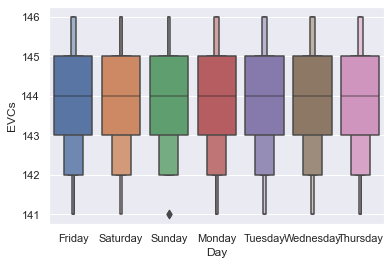

In [117]:
graph_by_day()

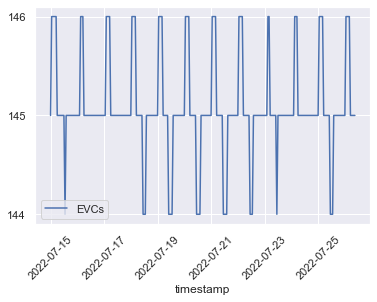

In [17]:
graph_EVC_capacity()

In [148]:
transformer_summary()

Summary for transformer transformer_92 between 2021-01-01 and 2022-07-23
Maximum excess capacity: 730.849 kVA                   Minimum excess capacity: 706.368 kVA
Maximum chargers using all excess capacity: 146        Minimum chargers using all excess capacity: 141


In [6]:
a = transformer_aggregate('transformer_16', '2022-07-10', '2022-07-20')

In [13]:
parse_date_time(a)

,Excess Capacity,weekday,year,month,day
timestamp,,,,,
2022-07-10 00:00:00,3.426,Sunday,2022,7,10
2022-07-10 01:00:00,3.757,Sunday,2022,7,10
2022-07-10 02:00:00,3.920,Sunday,2022,7,10
2022-07-10 03:00:00,3.938,Sunday,2022,7,10
2022-07-10 04:00:00,3.977,Sunday,2022,7,10
...,...,...,...,...,...
2022-07-19 20:00:00,2.637,Tuesday,2022,7,19
2022-07-19 21:00:00,2.667,Tuesday,2022,7,19
2022-07-19 22:00:00,3.000,Tuesday,2022,7,19


Okay, swinging for the fences here:

- give a transformer
- give EV charger stats
- specify transformer budget in % (i.e., we don't want to allocate more than 20% of the excess capacity)
- graph:
    - excess capacity (probably not)
    - budgeted capacity curve
    - max that fits globally
    - max that fits say between 10pm and 6am?
    
- then report:
    - max that fits globally
    - max that fits during offpeak hours
    - number that need to be shut off during peak hours?


Here's a more specialized function: it graphs the daily minimum capacity, the daily minimum capacity based on the hours of 10pm to 4am (i.e., night).

Then it graphs four lines:
   - EV threshold assuming never passing budget
   - EV threshold assuming never passing budget at night
   - EV threshold assuming never passing budget during summer
   - EV threshold assuming never passing budget during summer night

In [16]:
setup()

Charger power draw in kW: 5
Charger voltage in V: 120
Transformer ID: transformer_92
Start date and time of range: 2022-07-15
Start date and time of range: 2022-07-30


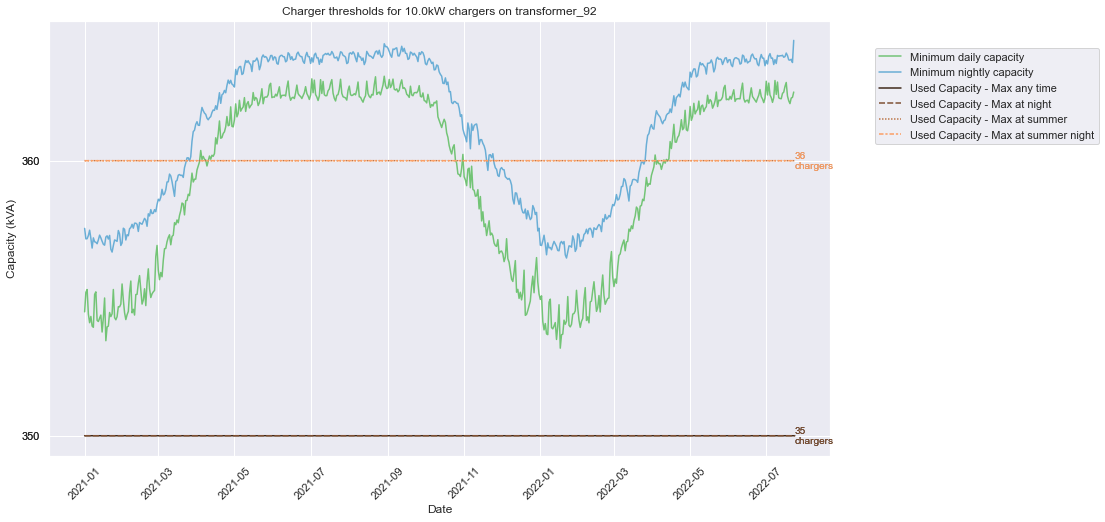

In [13]:
graph_power_scenarios(0.5)

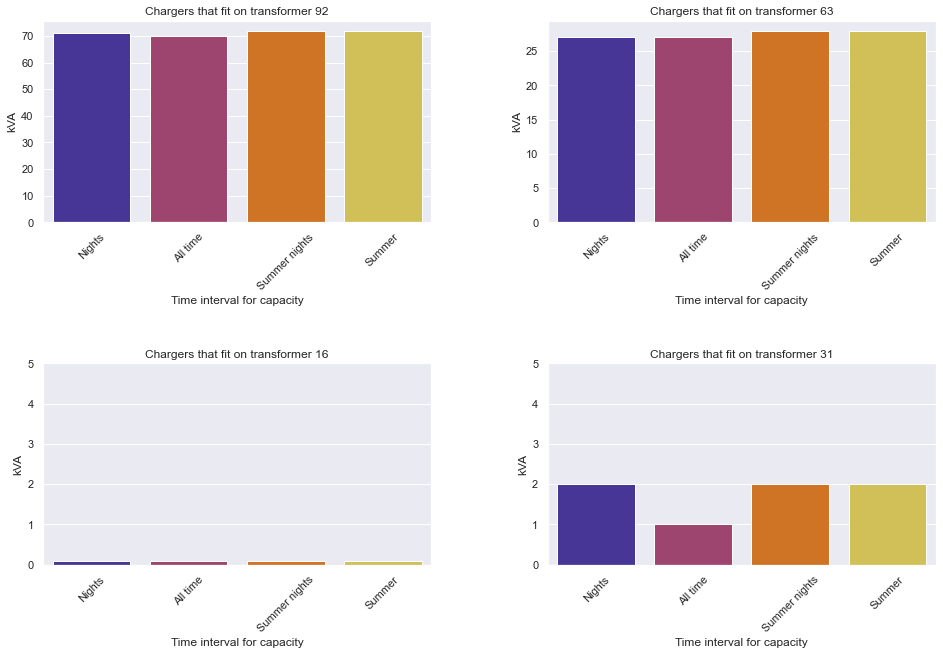

In [135]:
graph_chargers_on(transformers = ['transformer_92', 'transformer_63', 'transformer_16', 'transformer_31'])